In [1]:
import pandas as pd
from pathlib import Path

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display

# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

# PCA
from sklearn.decomposition import PCA

### STEP 2: EDA LEVEL 1
#### - Exploratory Data Analysis (EDA) 
#### - Level 1: Descriptive & Distribution

In [2]:
# STEP 2.0 - LOAD DATA FROM CSV (from 1_dataset_construction.ipynb)

# Define paths
ROOT = Path.cwd().parents[0]
INPUT_DIR = ROOT / "analysis" / "data" 
csv_path = INPUT_DIR / "final_jobs_500k.csv" # load global 500k data
print("csv_path: ", csv_path)

# Load data into DataFrame
df = pd.read_csv(
    csv_path,
    low_memory=False
)

# Display settings for unlimited rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30) # Adjust the maximum column width

df.head()

csv_path:  d:\Work_Study\IT\Data\Projects\data_industry_insights\analysis\data\final_jobs_500k.csv


,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories
0,69,49,4,2025-07-22,114400.0,135200.0,NaN,NaN,Bachelor,Full-time,We’re looking for a curiou...,Remote,Adverity,NaN,Technology,Vienna,United States of America,US,45.70562800215178,-112.5994359115045,328239523.0,Data Analyst,Senior,NaN,NaN,NaN
1,73,51,2,2025-09-30,NaN,NaN,NaN,8.0,Master,Full-time,Job Title: Q&A Manager Bas...,Remote,Axiom Software Solutions L...,NaN,Technology,NaN,Austria,AT,47.6139487927463,14.076158884337072,8877067.0,Data Manager,Lead,NaN,NaN,NaN
2,82,57,4,2025-11-13,NaN,NaN,NaN,NaN,Bachelor,Full-time,Datenanalystin/Datenanalys...,Remote,VOLKSBANK WIEN AG,NaN,Technology,Vienna,United States of America,US,45.70562800215178,-112.5994359115045,328239523.0,"Data Analyst,BI Developer,...",Senior,NaN,NaN,NaN
3,84,49,4,2025-12-02,NaN,NaN,NaN,NaN,Bachelor,Full-time,We are looking for a creat...,Remote,Adverity,NaN,Technology,Vienna,United States of America,US,45.70562800215178,-112.5994359115045,328239523.0,Data Analyst,Lead,NaN,NaN,NaN
4,103,51,2,2025-09-30,NaN,NaN,NaN,8.0,Master,Full-time,Job Title: Output Manageme...,Remote,Axiom Software Solutions L...,NaN,Technology,NaN,Austria,AT,47.6139487927463,14.076158884337072,8877067.0,NaN,Mid,NaN,NaN,NaN


In [3]:
# STEP 2.1: PREPARE DATA FOR ANALYSIS

# Convert 'posted_date' to datetime
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')

# Convert coordinate and population columns to numeric
numeric_cols = ['latitude', 'longitude', 'population', 'min_salary', 'max_salary', 'required_exp_years']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optimize categorical columns
# Added 'job_level' here as it usually has fixed values (Senior, Junior, etc.)
categorical_cols = [
    'employment_type', 'remote_option', 'education_level',
    'size', 'industry', 'country', 'country_iso', 'currency', 'job_level'
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Handle ID columns
id_cols = ['job_id', 'company_id', 'location_id', 'skill_ids']
for col in id_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

# Ensure new text-based columns are clean strings
text_cols = ['roles', 'skill_names', 'skill_categories']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).replace('None', pd.NA)

# Verify the changes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513473 entries, 0 to 513472
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   job_id              513473 non-null  object        
 1   company_id          513473 non-null  object        
 2   location_id         513473 non-null  object        
 3   posted_date         513473 non-null  datetime64[ns]
 4   min_salary          4332 non-null    float64       
 5   max_salary          4332 non-null    float64       
 6   currency            319 non-null     category      
 7   required_exp_years  722 non-null     float64       
 8   education_level     12774 non-null   category      
 9   employment_type     513473 non-null  category      
 10  job_description     513473 non-null  object        
 11  remote_option       513473 non-null  category      
 12  company_name        513473 non-null  object        
 13  size                22738 non

In [4]:
# STEP 2.2: CHECK CURRENCY COUNTS

# Detailed statistics for each currency unit
# value_counts(dropna=False) ensures we see the count for missing values (NaN)
currency_stats = df['currency'].value_counts(dropna=False).reset_index()
currency_stats.columns = ['Currency Unit', 'Row Count']

# Add a percentage column for better context
currency_stats['Percentage (%)'] = (currency_stats['Row Count'] / len(df) * 100).round(2)

print("--- Detailed Currency Statistics ---")
print(currency_stats)

# Summary of unique units
unique_units = df['currency'].nunique()
missing_values = df['currency'].isna().sum()

print(f"\nSummary:")
print(f"- Total unique currency units found: {unique_units}")
print(f"- Total rows missing currency (NaN): {missing_values} ({ (missing_values/len(df)*100):.2f}%)")

--- Detailed Currency Statistics ---
  Currency Unit  Row Count  Percentage (%)
0           NaN     513154           99.94
1           USD        286            0.06
2           EUR         16            0.00
3           PLN         10            0.00
4           INR          3            0.00
5           CHF          2            0.00
6           GBP          1            0.00
7           AUD          1            0.00

Summary:
- Total unique currency units found: 7
- Total rows missing currency (NaN): 513154 (99.94%)


In [5]:
# STEP 2.3: CONVERT ALL CURRENCY TO USD ---

# Fill missing currencies with 'USD' ONLY IF there is salary data
# This fulfills your requirement: "rows with min/max salary but empty currency -> fill as USD"
mask_missing_currency = (df['currency'].isna()) & (df['min_salary'].notna() | df['max_salary'].notna())
df.loc[mask_missing_currency, 'currency'] = 'USD'

# Define Exchange Rates (Update these values if needed)
exchange_rates = {
    'USD': 1.0,
    'EUR': 1.08,
    'PLN': 0.25,
    'INR': 0.012,
    'CHF': 1.15,
    'GBP': 1.27,
    'AUD': 0.66
}

# Map exchange rates (Default to 1.0 if still unknown)
df['ex_rate'] = df['currency'].map(exchange_rates).astype(float).fillna(1.0)

# Convert salary columns to USD
df['min_salary_usd'] = df['min_salary'] * df['ex_rate']
df['max_salary_usd'] = df['max_salary'] * df['ex_rate']

# Calculate average salary in USD
df['avg_salary_usd'] = df[['min_salary_usd', 'max_salary_usd']].mean(axis=1)

# Final Check
print("--- Final Salary Conversion Summary ---")
print(f"Total rows forced to USD (missing currency but had salary): {mask_missing_currency.sum()}")
print(f"Total jobs with valid USD salary: {df['avg_salary_usd'].notnull().sum()}")
print("\nSample of converted data:")
print(df[df['avg_salary_usd'].notnull()][['currency', 'min_salary', 'max_salary', 'avg_salary_usd']].head(10))

--- Final Salary Conversion Summary ---
Total rows forced to USD (missing currency but had salary): 4026
Total jobs with valid USD salary: 4332

Sample of converted data:
    currency  min_salary  max_salary  avg_salary_usd
0        USD    114400.0    135200.0        124800.0
16       USD     46800.0     88400.0         67600.0
18       USD    287040.0    301600.0        294320.0
21       USD     62400.0     93600.0         78000.0
22       EUR     60000.0     60000.0         64800.0
24       USD     53802.0     53802.0         53802.0
76       USD     53802.0     53802.0         53802.0
113      USD    195000.0    195000.0        195000.0
135      USD    343200.0    343200.0        343200.0
142      GBP    384000.0    420000.0        510540.0


In [6]:
# STEP 2.4: CHECK MISSING SALARY AND FILL

# Check missing values come from what countries
missing = df[df['min_salary_usd'].isna()][['country', 'currency']] # Show rows with missing salary usd, and show 2 columns

 # Drop duplicates countries
country_count_NA = missing.drop_duplicates()

# Summary
print("Total countrys with missing data:", len(country_count_NA))
print(country_count_NA)

Total countrys with missing data: 170
                              country currency
1                             Austria      NaN
2            United States of America      NaN
25                            Germany      NaN
193                            Poland      NaN
217                         Australia      NaN
223                              Cuba      NaN
243                      South Africa      NaN
300                            Canada      NaN
323                         Hong Kong      NaN
485                       New Zealand      NaN
507                         Australia      USD
932                    United Kingdom      NaN
1091                          Belgium      NaN
1105                      Netherlands      NaN
1125                    Côte d'Ivoire      NaN
1461                           Brazil      NaN
1495                      Philippines      NaN
1501                           Mexico      NaN
1504                        Indonesia      NaN
1519                  

In [7]:
# STEP 2.4: CHECK MISSING SALARY AND FILL

# Calculate average salary in USD

df_avg_salary = df.groupby(['country', 'currency']).agg(
    jobs=('job_id', 'count'),
    avg_salary_usd=('avg_salary_usd', 'mean')
).reset_index()

df_avg_salary.head()

C:\Users\Zyro\AppData\Local\Temp\ipykernel_15596\4129969560.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_salary = df.groupby(['country', 'currency']).agg(


,country,currency,jobs,avg_salary_usd
0,Afghanistan,AUD,0,NaN
1,Afghanistan,CHF,0,NaN
2,Afghanistan,EUR,0,NaN
3,Afghanistan,GBP,0,NaN
4,Afghanistan,INR,0,NaN


In [8]:
# STEP 2.4: CHECK MISSING SALARY AND FILL

# Summary

salary_cols = ['min_salary_usd', 'max_salary_usd', 'avg_salary_usd']

# min, median (50%), mean, max
summary = df[salary_cols].agg(['min', 'median', 'mean', 'max']).T

# Format USD
summary_formatted = summary.applymap(lambda x: f"${x:,.2f}")

summary_formatted.rename(columns={
    'min': 'Minimum',
    'median': 'Median',
    'mean': 'Average',
    'max': 'Maximum'
}, inplace=True)

# Visual
print("\n" + "="*50)
print("💼 SALARY SUMMARY (USD) 💼")
print("="*50)
print(summary_formatted)


💼 SALARY SUMMARY (USD) 💼
                Minimum       Median      Average      Maximum
min_salary_usd  $600.00  $100,000.00  $133,275.78  $487,680.00
max_salary_usd  $960.00  $110,000.00  $152,920.60  $533,400.00
avg_salary_usd  $780.00  $104,022.06  $143,098.19  $510,540.00


C:\Users\Zyro\AppData\Local\Temp\ipykernel_15596\1164374639.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_formatted = summary.applymap(lambda x: f"${x:,.2f}")


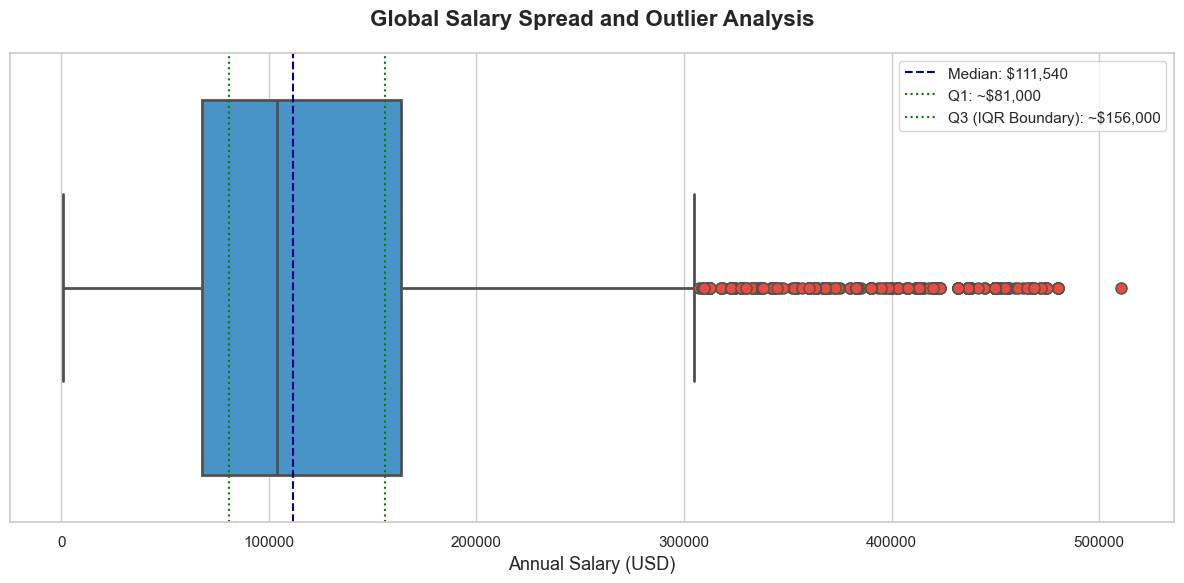

In [11]:
# STEP 2.5: CHARTS GLOBAL SALARY SPREAD

# Set plot style and size
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the Boxplot
# Change 'avg_salary_usd' to match your actual column name exactly
ax = sns.boxplot(x=df['avg_salary_usd'],
                 color='#3498db',
                 linewidth=2,
                 flierprops={'markerfacecolor':'#e74c3c', 'marker':'o', 'markersize':8})

# Add titles and labels in English
plt.title('Global Salary Spread and Outlier Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Annual Salary (USD)', fontsize=13)

# Annotating key statistics (Values based on your Section 3.2 data)
median_val = 111540
q1_val = 81000   # Approximate 25th percentile
q3_val = 156000  # Approximate 75th percentile

# Draw vertical lines for better visualization
plt.axvline(median_val, color='darkblue', linestyle='--', label=f'Median: ${median_val:,.0f}')
plt.axvline(q1_val, color='green', linestyle=':', label=f'Q1: ~${q1_val:,.0f}')
plt.axvline(q3_val, color='green', linestyle=':', label=f'Q3 (IQR Boundary): ~${q3_val:,.0f}')

# Display Legend
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# STEP 2.6: DESCRIBE

# For Numbers
print("--- NUMERICAL STATS ---")
display(df.describe())

# For Text
print("\n--- CATEGORICAL STATS ---")
display(df.describe(include='object'))

--- NUMERICAL STATS ---


,posted_date,min_salary,max_salary,required_exp_years,latitude,longitude,population,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd
count,513473,4332.000000,4332.000000,722.000000,512816.000000,512816.000000,5.128160e+05,513473.000000,4332.000000,4332.000000,4332.000000
mean,2024-05-16 09:56:51.528161792,133380.154771,153036.120838,4.569252,34.885220,-36.105454,2.069520e+08,0.999983,133275.776526,152920.596295,143098.186410
min,2021-04-17 00:00:00,20800.000000,23400.000000,0.000000,-41.662579,-157.429600,1.300000e+04,0.012000,600.000000,960.000000,780.000000
25%,2023-10-15 00:00:00,65000.000000,70251.030000,3.000000,23.935372,-112.599436,5.855827e+07,1.000000,65000.000000,70000.000000,67597.500000
50%,2024-01-12 00:00:00,100000.000000,110000.000000,5.000000,42.751183,-8.055766,8.313280e+07,1.000000,100000.000000,110000.000000,104022.060000
75%,2024-11-22 00:00:00,156000.000000,168716.605000,6.000000,45.705628,12.140788,3.282395e+08,1.000000,156000.000000,168716.605000,163480.920000
max,2025-12-31 00:00:00,480000.000000,500000.000000,20.000000,65.074276,172.701926,1.397715e+09,1.270000,487680.000000,533400.000000,510540.000000
std,NaN,95842.968588,119705.057210,2.230490,20.012355,77.107302,2.684999e+08,0.004161,95936.791787,119877.499109,107153.991488



--- CATEGORICAL STATS ---


,job_id,company_id,location_id,job_description,company_name,city,roles,skill_names,skill_ids,skill_categories
count,513473,513473,513473,513473,513473,403980,513473,513473,513473,513473
unique,513473,105288,8353,5072,105288,8333,109,92121,92121,3257
top,69,37815,5370,__NA__,Emprego,Singapore,Data Engineer,nan,nan,nan
freq,1,7039,106854,496199,7039,15546,187099,99050,99050,99050


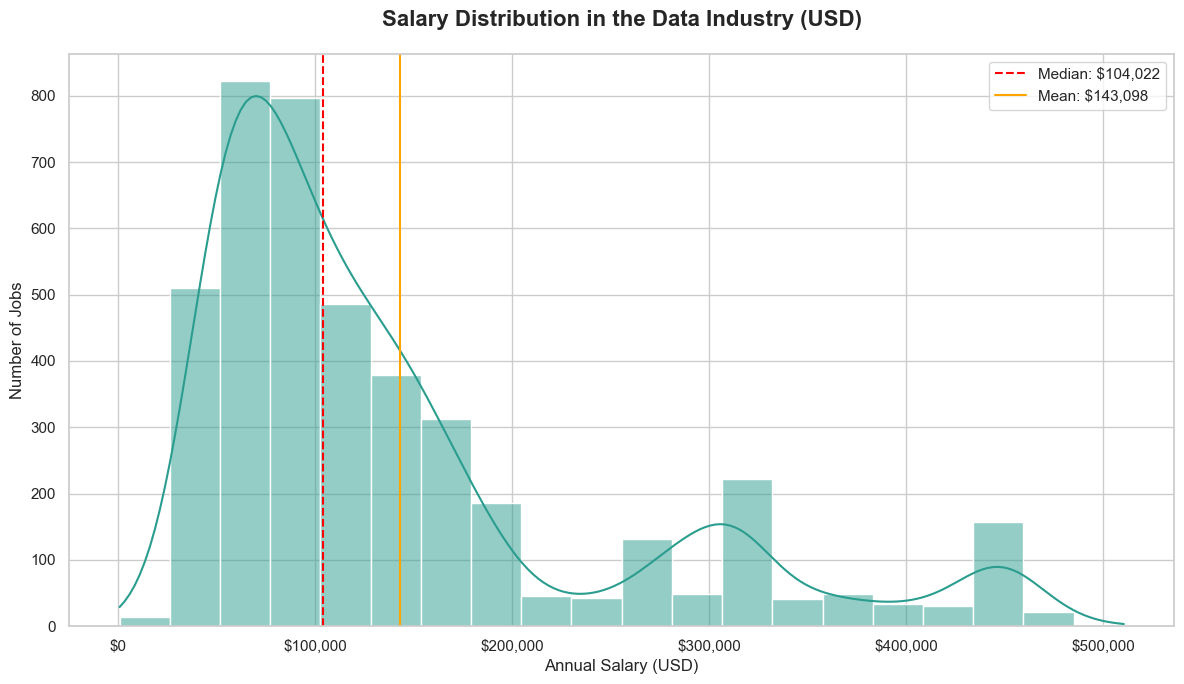

In [ ]:
# STEP 2.7: CHARTS SALARY DISTRIBUTION

# Filter data to include only non-null salary records
salary_data = df[df['avg_salary_usd'].notnull()]

# Set the visual theme
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Create Histogram with Kernel Density Estimate (KDE)
# This shows the shape of the distribution
sns.histplot(salary_data['avg_salary_usd'], kde=True, color='#2a9d8f', bins=20)

# Add vertical lines for statistical context
# These lines help identify if the data is skewed
median_val = salary_data['avg_salary_usd'].median()
mean_val = salary_data['avg_salary_usd'].mean()

plt.axvline(median_val, color='red', linestyle='--', label=f'Median: ${median_val:,.0f}')
plt.axvline(mean_val, color='orange', linestyle='-', label=f'Mean: ${mean_val:,.0f}')

# Add Titles and Labels
plt.title('Salary Distribution in the Data Industry (USD)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Annual Salary (USD)', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.legend()

# Format the X-axis to show currency
formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)

# Adjust spacing
plt.tight_layout()
plt.show()

C:\Users\Zyro\AppData\Local\Temp\ipykernel_15596\1241357939.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


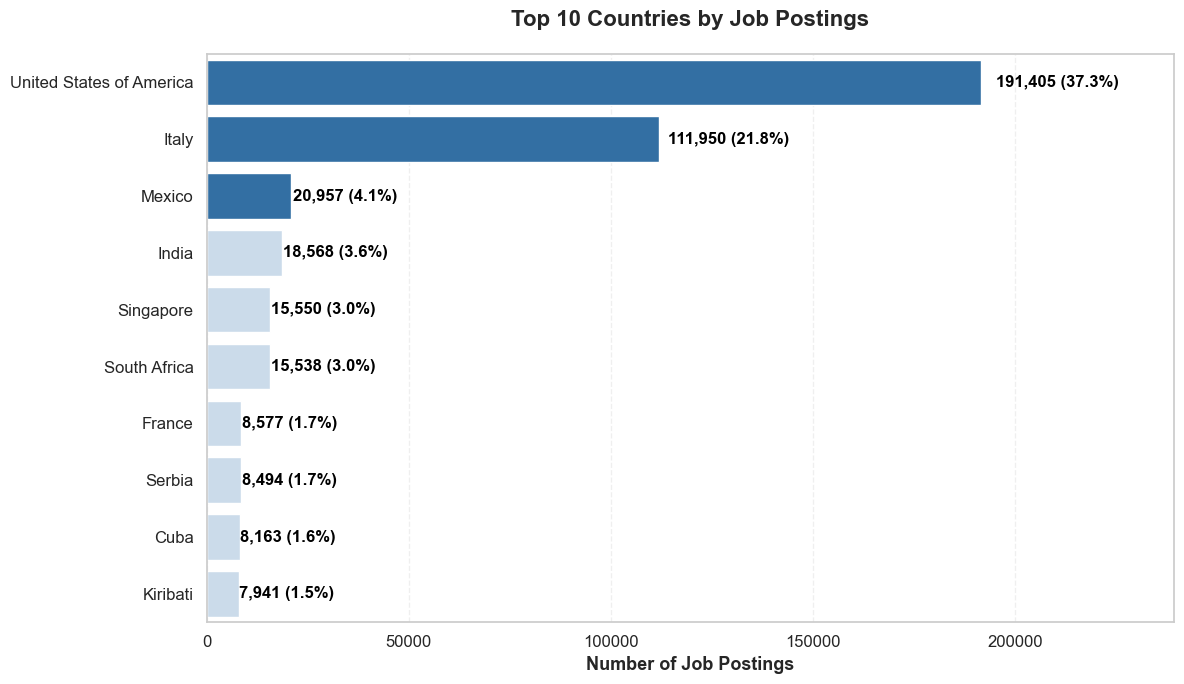

In [ ]:
# STEP 2.8: TOP 10 COUNTRIES BY JOB POSTINGS

# STEP 2.8.1: Clear previous figures
plt.close('all')

# STEP 2.8.2: Top 10 countries
top_10_df = df['country'].value_counts().head(10).reset_index()
top_10_df.columns = ['Country', 'JobCount']

top_10_df['Country'] = top_10_df['Country'].astype(str)

# STEP 2.8.3: Percentage
total_jobs = len(df)
top_10_df['Pct'] = (top_10_df['JobCount'] / total_jobs) * 100

# STEP 2.8.4: Plot
plt.figure(figsize=(12, 7))

# Professional colors
base_color = '#C6DBEF'
highlight_color = '#2171B5'

bar_colors = (
    [highlight_color] * 3 +
    [base_color] * (len(top_10_df) - 3)
)

sns.barplot(
    data=top_10_df,
    x='JobCount',
    y='Country',
    palette=bar_colors
)

# 5. Labels (Count + %)
for i, row in top_10_df.iterrows():
    label = f"{int(row['JobCount']):,} ({row['Pct']:.1f}%)"
    plt.text(
        row['JobCount'] * 1.02,
        i,
        label,
        va='center',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

plt.title(
    'Top 10 Countries by Job Postings',
    fontsize=16,
    fontweight='bold',
    pad=20
)

plt.xlabel(
    'Number of Job Postings',
    fontsize=13,
    fontweight='bold'
)

plt.ylabel('')
plt.xlim(0, top_10_df['JobCount'].max() * 1.25)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Zyro\AppData\Local\Temp\ipykernel_15596\793214756.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_edu, x='avg_salary_usd', hue='education_level', fill=True, common_norm=False, palette='viridis', alpha=.5)


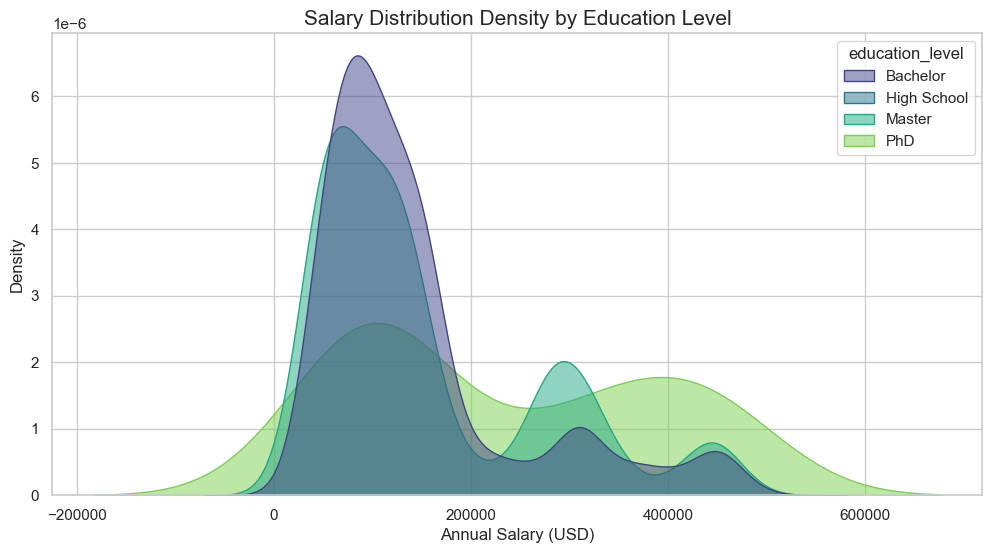

In [ ]:
# STEP 2.9: CHARTS SALARY DISTRIBUTION BY EDUCATION LEVEL

# Filter for rows that have both salary and education level
df_edu = df[df['avg_salary_usd'].notnull() & df['education_level'].notnull()]

# Plotting
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_edu, x='avg_salary_usd', hue='education_level', fill=True, common_norm=False, palette='viridis', alpha=.5)

# Add vertical lines for median salaries by education level
plt.title('Salary Distribution Density by Education Level', fontsize=15)
plt.xlabel('Annual Salary (USD)')
plt.ylabel('Density')
plt.show()

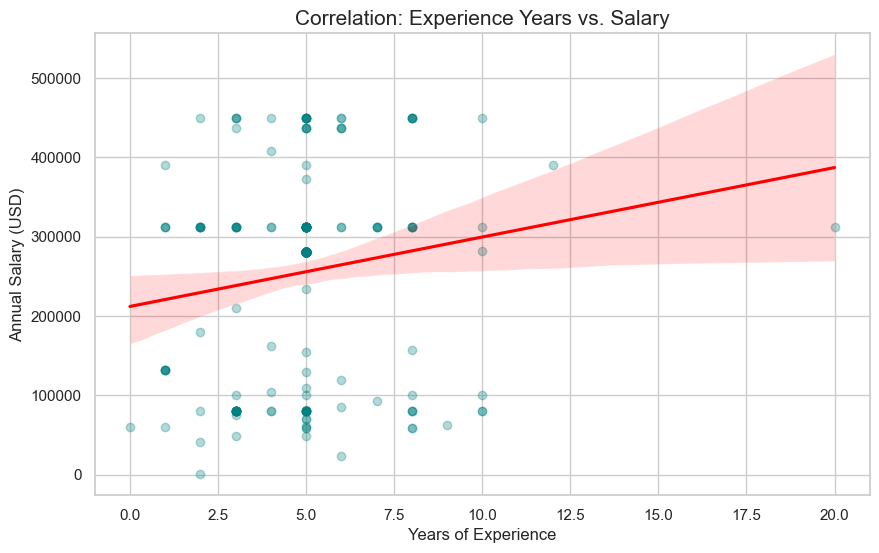

In [ ]:
# STEP 2.10: CHARTS EXPERIENCE VS. SALARY

# Charts the relationship between years of experience and salary
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='required_exp_years', y='avg_salary_usd',
            scatter_kws={'alpha':0.3, 'color':'teal'}, line_kws={'color':'red'})

# Add title and labels
plt.title('Correlation: Experience Years vs. Salary', fontsize=15)
plt.xlabel('Years of Experience')
plt.ylabel('Annual Salary (USD)')
plt.show()

In [ ]:
# STEP 2.10: CHARTS EXPERIENCE VS. SALARY

# Check correlation by Pearson and Spearman (2.10 Expanse)
df_corr_pearson = df[['required_exp_years', 'avg_salary_usd']].corr(method='pearson')
df_corr_spearman = df[['required_exp_years', 'avg_salary_usd']].corr(method='spearman')

# Visual
print("Correlation (Pearson):")
print(df_corr_pearson, "\n")
print("Correlation (Spearman):")
print(df_corr_spearman)

Correlation (Pearson):
                    required_exp_years  avg_salary_usd
required_exp_years             1.00000         0.15166
avg_salary_usd                 0.15166         1.00000 

Correlation (Spearman):
                    required_exp_years  avg_salary_usd
required_exp_years             1.00000         0.16975
avg_salary_usd                 0.16975         1.00000


<Figure size 640x480 with 0 Axes>

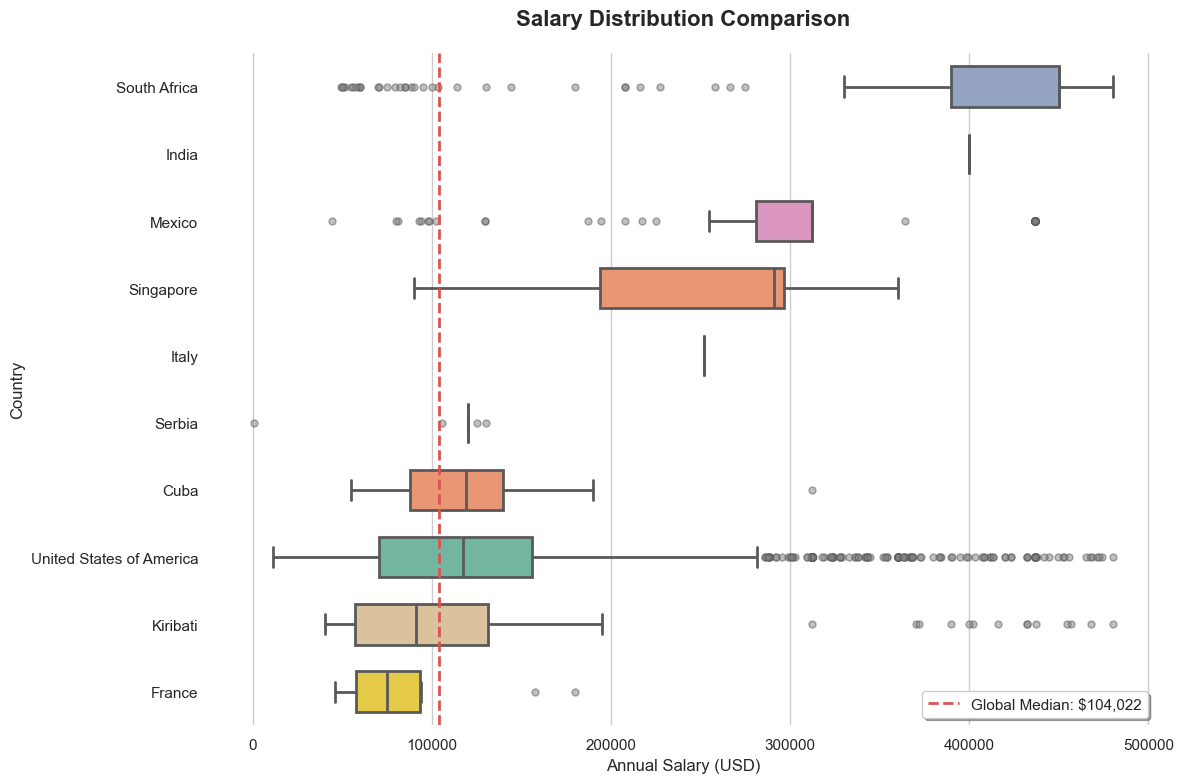

In [ ]:
# STEP 2.11: CHARTS SALARY DISTRIBUTION BY COUNTRY

# Total Reset of the plotting environment
plt.close('all')
plt.cla()
plt.clf()

# Identify the REAL Top 10 countries by volume (number of job listings)
# This prevents rare countries from appearing in the Top 10
top_10_names = df['country'].value_counts().nlargest(10).index.tolist()

# Force-create a new DataFrame to break all categorical memory
# We use .copy() and reset_index to ensure a clean slate
df_plot = df[df['country'].isin(top_10_names)].copy()
df_plot['country'] = df_plot['country'].astype(str)

# Sorting logic for a professional hierarchy
order_list = df_plot.groupby('country')['avg_salary_usd'].median().sort_values(ascending=False).index

# Visual Configuration (Solid Light Colors - Professional Style)
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Using 'Set2' for professional, solid light colors
ax = sns.boxplot(
    data=df_plot,
    y='country',
    x='avg_salary_usd',
    order=order_list,
    hue='country',
    palette='Set2',
    width=0.6,
    linewidth=2,
    fliersize=5,
    flierprops={'markerfacecolor': 'gray', 'alpha': 0.5}
)

# Global Median Benchmark Line (Red)
global_med = df['avg_salary_usd'].median()
plt.axvline(global_med, color='#d9534f', linestyle='--', linewidth=2, label=f'Global Median: ${global_med:,.0f}')

# Professional English Labels
plt.title('Salary Distribution Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Annual Salary (USD)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(loc='lower right', frameon=True, shadow=True)

# Remove outer spines for clarity
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

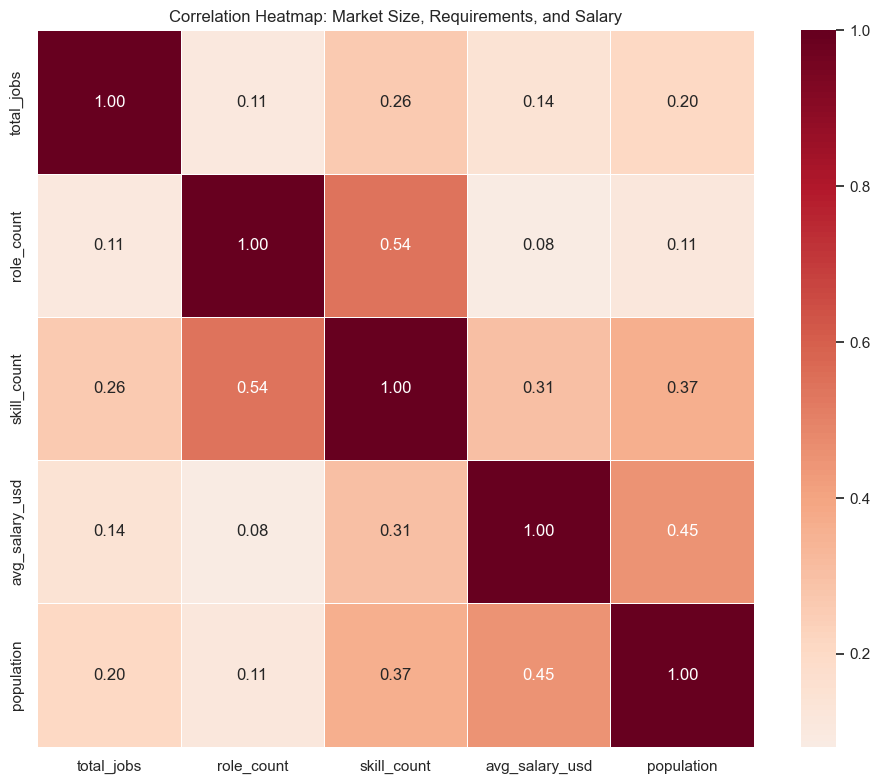

In [19]:
# STEP 2.12 : CORRELATION HEATMAP

import matplotlib.pyplot as plt
import seaborn as sns

# Item Counting Function
def count_items(text):
    if pd.isna(text) or str(text).strip() == "" or str(text).lower() in ['none', 'nan']:
        return 0
    # Count based on commas
    return len([i.strip() for i in str(text).split(',') if i.strip() != ""])

# FIX: Ensure columns exist and use the correct names from your dataset
# We use 'skill_names' because that is what your dataset actually contains.
if 'skills' not in df.columns and 'skill_names' in df.columns:
    df['skills'] = df['skill_names'].astype(str).replace(['nan', 'None'], '')
elif 'skills' not in df.columns:
    df['skills'] = ""

if 'roles' in df.columns:
    df['roles'] = df['roles'].astype(str).replace(['nan', 'None'], '')
else:
    df['roles'] = ""

# Create count columns for heatmap
df['role_count'] = df['roles'].apply(count_items)
df['skill_count'] = df['skills'].apply(count_items)

# Convert critical columns to numeric (Ensuring avg_salary_usd is included)
cols_to_fix = ['avg_salary_usd', 'population', 'role_count', 'skill_count']
for col in cols_to_fix:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Group by Country
# Use observed=True to handle Categorical types correctly
df_country_stats = df.groupby('country', observed=True).agg({
    'job_id': 'count',
    'role_count': 'mean',
    'skill_count': 'mean',
    'avg_salary_usd': 'mean', # Using the USD standardized salary we created
    'population': 'mean'      # Using mean population in case of duplicate entries
}).rename(columns={'job_id': 'total_jobs'})

# Cleaning: Remove countries with no data to avoid NaN in correlation matrix
df_country_stats = df_country_stats.dropna()

# Plot Correlation Heatmap
plt.figure(figsize=(10, 8))
country_corr = df_country_stats.corr()

sns.heatmap(country_corr,
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt=".2f",
            square=True,
            linewidths=.5)

plt.title('Correlation Heatmap: Market Size, Requirements, and Salary')
plt.tight_layout()
plt.show()

In [20]:
# STEP 2.12: ANOVA ANALYSIS

# Pre-processing: Align column names and metrics
# We use the 'skills' and 'roles' columns prepared in Step 5
if 'skills' not in df.columns and 'skill_names' in df.columns:
    df['skills'] = df['skill_names'].astype(str).replace(['nan', 'None'], '')

# repare Data for ANOVA
# Filter only rows that have a valid salary (using our standardized USD column)
df_filtered = df.dropna(subset=['min_salary_usd'])

# Get Top 5 countries with the most salary data points for a valid test
top_countries = df_filtered['country'].value_counts().nlargest(5).index
df_anova_base = df_filtered[df_filtered['country'].isin(top_countries)].copy()

# Ensure country is a string to avoid categorical index errors in statsmodels
df_anova_base['country'] = df_anova_base['country'].astype(str)

# List of Metrics to test
factors_to_test = ['skill_count', 'min_salary_usd', 'role_count']

print(f"=== ANOVA ANALYSIS REPORT: TOP 5 COUNTRIES ===")
print(f"Countries analyzed: {', '.join(top_countries)}\n")

for factor in factors_to_test:
    # Clean data for the specific factor
    df_clean = df_anova_base.dropna(subset=[factor, 'country'])

    # Check if there's enough data (need at least some rows per country)
    if df_clean.empty or len(df_clean['country'].unique()) < 2:
        print(f"Skipping {factor}: Not enough data for comparison.\n")
        continue

    # Build OLS Model and Run ANOVA
    # C(country) treats the country names as categorical groups
    try:
        formula = f'{factor} ~ C(country)'
        model = ols(formula, data=df_clean).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Business Format Display
        print(f"--- ANOVA RESULTS FOR: {factor.upper()} ---")

        p_val = anova_table['PR(>F)'].iloc[0]
        f_stat = anova_table['F'].iloc[0]

        print(f"F-statistic: {f_stat:.4f}")

        if p_val < 0.05:
            print(f"Result: STATISTICALLY SIGNIFICANT (P-value = {p_val:.4e})")
            print(f"Insight: Geography (Country) has a real impact on {factor}.")
        else:
            print(f"Result: NOT SIGNIFICANT (P-value = {p_val:.4f})")
            print(f"Insight: No strong evidence that Country affects {factor}.")

        display(anova_table)
        print("-" * 50)
    except Exception as e:
        print(f"Error analyzing {factor}: {e}")

=== ANOVA ANALYSIS REPORT: TOP 5 COUNTRIES ===
Countries analyzed: United States of America, Kiribati, United Kingdom, Mexico, Russia

--- ANOVA RESULTS FOR: SKILL_COUNT ---
F-statistic: 34.3110
Result: STATISTICALLY SIGNIFICANT (P-value = 3.8406e-28)
Insight: Geography (Country) has a real impact on skill_count.


,sum_sq,df,F,PR(>F)
C(country),21.876905,4.0,34.310959,3.840599e-28
Residual,567.629545,3561.0,NaN,NaN


--------------------------------------------------
--- ANOVA RESULTS FOR: MIN_SALARY_USD ---
F-statistic: 253.8816
Result: STATISTICALLY SIGNIFICANT (P-value = 3.8674e-192)
Insight: Geography (Country) has a real impact on min_salary_usd.


,sum_sq,df,F,PR(>F)
C(country),5.735189e+12,4.0,253.881568,3.867385e-192
Residual,2.011076e+13,3561.0,NaN,NaN


--------------------------------------------------
--- ANOVA RESULTS FOR: ROLE_COUNT ---
F-statistic: 15.2386
Result: STATISTICALLY SIGNIFICANT (P-value = 2.3269e-12)
Insight: Geography (Country) has a real impact on role_count.


,sum_sq,df,F,PR(>F)
C(country),35.614624,4.0,15.238616,2.326883e-12
Residual,2080.629907,3561.0,NaN,NaN


--------------------------------------------------


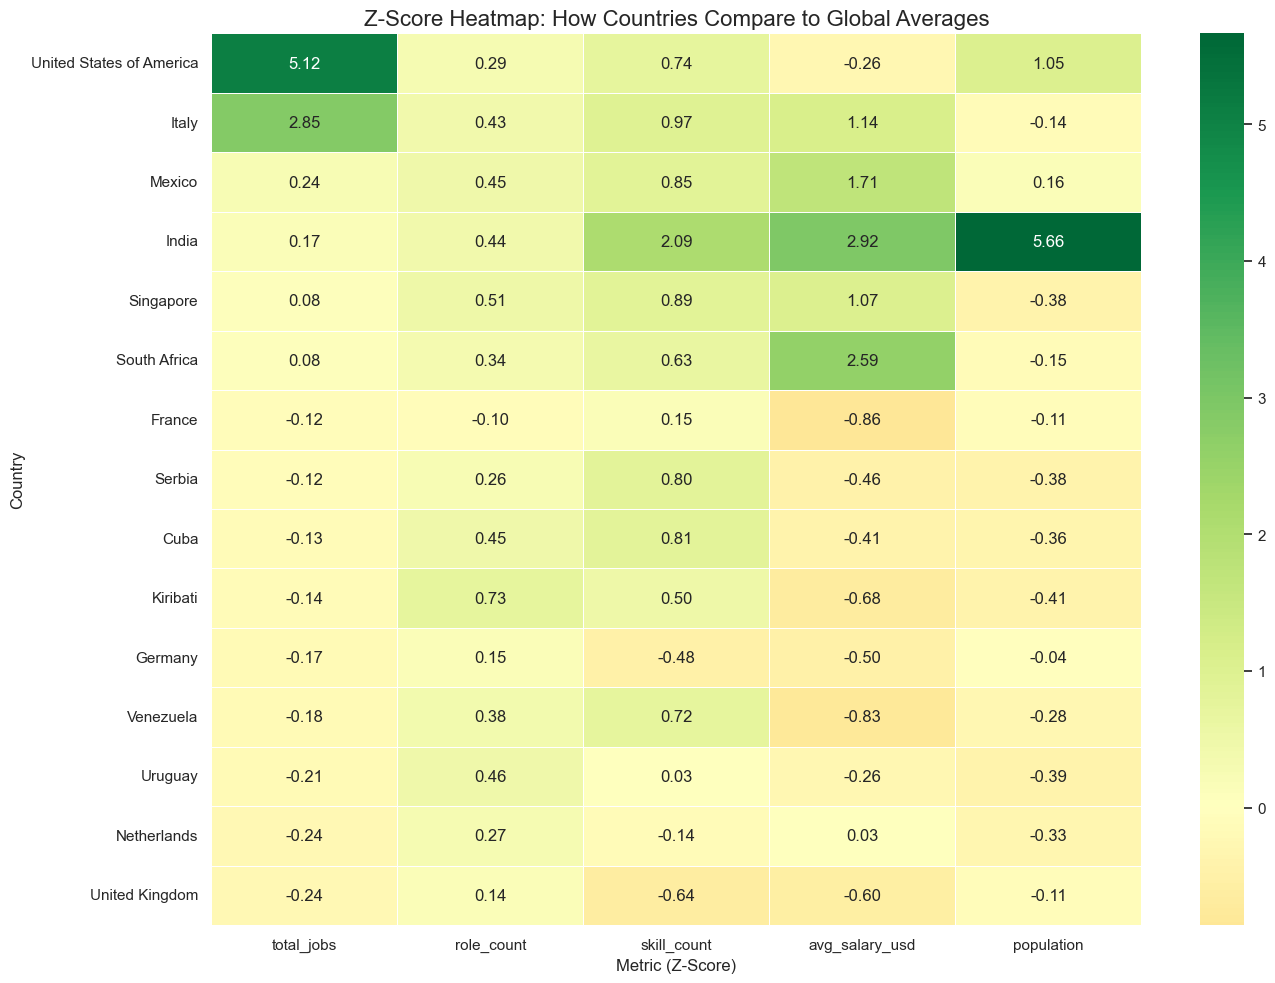

In [22]:
# STEP 2.13: Z - SCORE ANALYSIS
from scipy.stats import zscore

# Select key metrics for Z-Score analysis
# Using the aggregated df_country_stats from Step 5
cols_to_zscore = ['total_jobs', 'role_count', 'skill_count', 'avg_salary_usd', 'population']

# Compute Z-scores (z = (x - mean) / std)
# We handle potential NaN or infinity results to keep the heatmap clean
df_zscore = df_country_stats[cols_to_zscore].apply(zscore)

# Handle countries with very few data points if needed
# (Optional: Filter out countries with total_jobs below a certain threshold for cleaner stats)
# df_zscore = df_zscore[df_country_stats['total_jobs'] > 5]

# Visualization
plt.figure(figsize=(14, 10))

# Sorting by total_jobs to see how the biggest markets compare across other metrics
# Using RdYlGn (Red-Yellow-Green) where Green = Above Average, Red = Below Average
sns.heatmap(df_zscore.sort_values('total_jobs', ascending=False).head(15),
            annot=True,
            cmap='RdYlGn',
            center=0,
            fmt=".2f",
            linewidths=0.5)

# Formatting
plt.title('Z-Score Heatmap: How Countries Compare to Global Averages', fontsize=16)
plt.ylabel('Country')
plt.xlabel('Metric (Z-Score)')
plt.tight_layout()
plt.show()

### STEP 3: EDA LEVEL 2
#### - Exploratory Data Analysis (EDA) 
#### - Level 2: Relationships & Aggregation

C:\Users\Zyro\AppData\Local\Temp\ipykernel_15596\3015719967.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_stats = df.groupby('country').agg({


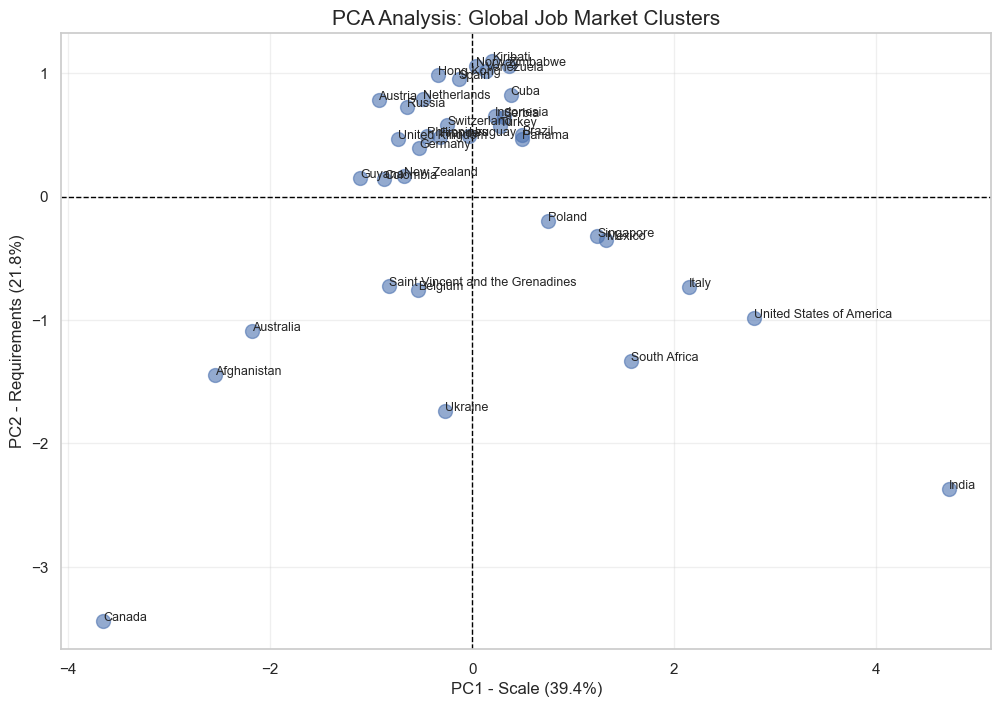

=== VARIABLE LOADINGS ===
                     PC1       PC2
total_jobs      0.357960 -0.219719
role_count      0.434701  0.660801
skill_count     0.599792  0.253034
min_salary      0.349184 -0.564372
population_num  0.448575 -0.364037


In [ ]:
# STEP 3.1: K-MEANS CLUSTERING

# STEP 3.1.1: FEATURE ENGINEERING & CLEANING ---
def count_items(text):
    if pd.isna(text) or str(text).strip() == "" or str(text).lower() == 'nan':
        return 0
    return len([i.strip() for i in str(text).split(',') if i.strip() != ""])

# Create proxy for roles from industry and skills from job_description
df['role_count'] = df['roles'].astype(str).apply(count_items)
df['skill_count'] = df['skills'].astype(str).apply(count_items)

# Convert salary and population to numeric, handling missing values with the median
df['min_salary_usd'] = pd.to_numeric(df['min_salary'], errors='coerce')
df['population_num'] = pd.to_numeric(df['population'], errors='coerce')

# STEP 3.1.2: AGGREGATION BY COUNTRY ---
# We aggregate to find the "average" market profile for each country
df_country_stats = df.groupby('country').agg({
    'job_id': 'count',
    'role_count': 'mean',
    'skill_count': 'mean',
    'min_salary': 'median', # Using median due to high sparsity in salary data
    'population_num': 'first'
}).rename(columns={'job_id': 'total_jobs'}).dropna()

# STEP 3.1.3: PCA EXECUTION
features = ['total_jobs', 'role_count', 'skill_count', 'min_salary', 'population_num']
x = df_country_stats[features]

# Standardize the data (Mean=0, Variance=1)
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(x_std)

# Create a DataFrame for the results
pca_df = pd.DataFrame(data=pc_scores,
                      columns=['PC1 (Market Scale)', 'PC2 (Job Requirements)'],
                      index=x.index)

# STEP 3.1.4: VISUALIZATION
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1 (Market Scale)'], pca_df['PC2 (Job Requirements)'], alpha=0.6, s=100)

for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=9)

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title('PCA Analysis: Global Job Market Clusters', fontsize=15)
plt.xlabel(f'PC1 - Scale ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 - Requirements ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.show()

# Show variable influence
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("=== VARIABLE LOADINGS ===")
print(loadings)

Clustering based on: ['PC1 (Market Scale)', 'PC2 (Job Requirements)']


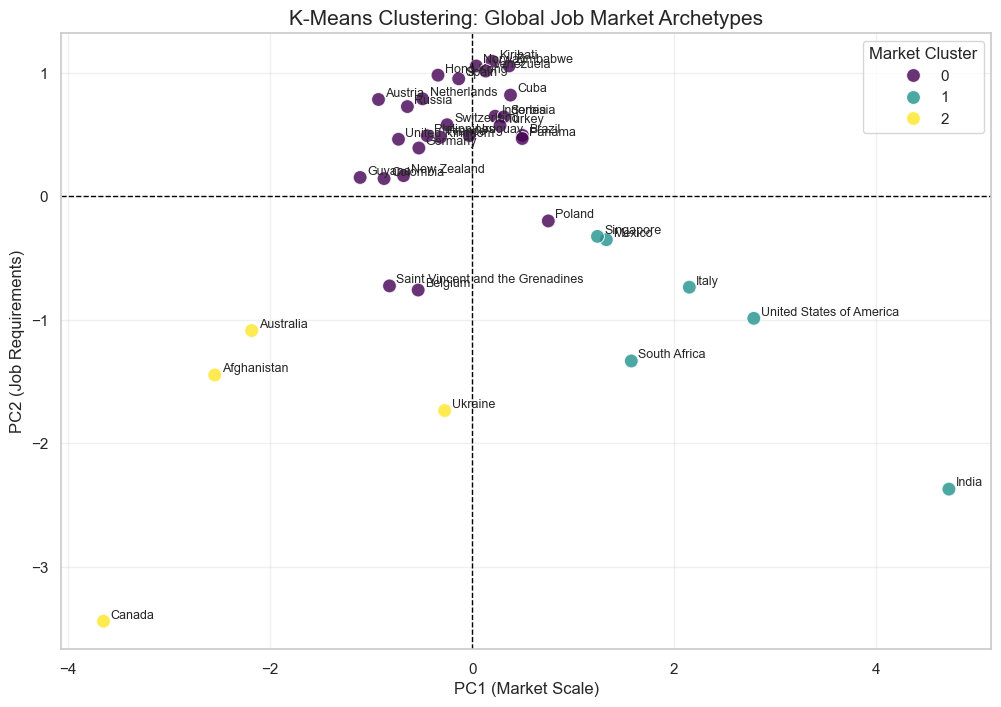

Cluster 0: Austria, Belgium, Brazil, Colombia, Cuba, France, Germany, Guyana, Hong Kong, Indonesia, Kiribati, Netherlands, New Zealand, Norway, Panama, Philippines, Poland, Russia, Saint Vincent and the Grenadines, Serbia, Spain, Switzerland, Turkey, United Kingdom, Uruguay, Venezuela, Zimbabwe
Cluster 1: India, Italy, Mexico, Singapore, South Africa, United States of America
Cluster 2: Afghanistan, Australia, Canada, Ukraine


In [ ]:
# STEP 3.2: K-MEANS CLUSTERING ON PCA SPACE

# STEP 3.2.1: Automatically detect the PCA column names to avoid KeyErrors
pca_cols = pca_df.columns[:2].tolist()
print(f"Clustering based on: {pca_cols}")

# STEP 3.2.2: Run K-Means
# We use .fit_predict() which is cleaner for assigning cluster labels
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[pca_cols])

# STEP 3.2.3: Visualize the Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x=pca_cols[0], y=pca_cols[1],
                hue='Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='w')

# Annotate country names for clarity
for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]),
                 fontsize=9, xytext=(5,2), textcoords='offset points')

plt.title('K-Means Clustering: Global Job Market Archetypes', fontsize=15)
plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.grid(True, alpha=0.3)
plt.legend(title='Market Cluster')
plt.show()

# STEP 3.2.4. View which countries fell into which cluster
for cluster_id in range(3):
    countries = pca_df[pca_df['Cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id}: {', '.join(countries)}")

### STEP 4: PCA
#### - Principal Component Analysis (PCA) 
#### - K-Means Clustering

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\100455573.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country_stats = df.groupby('country').agg({


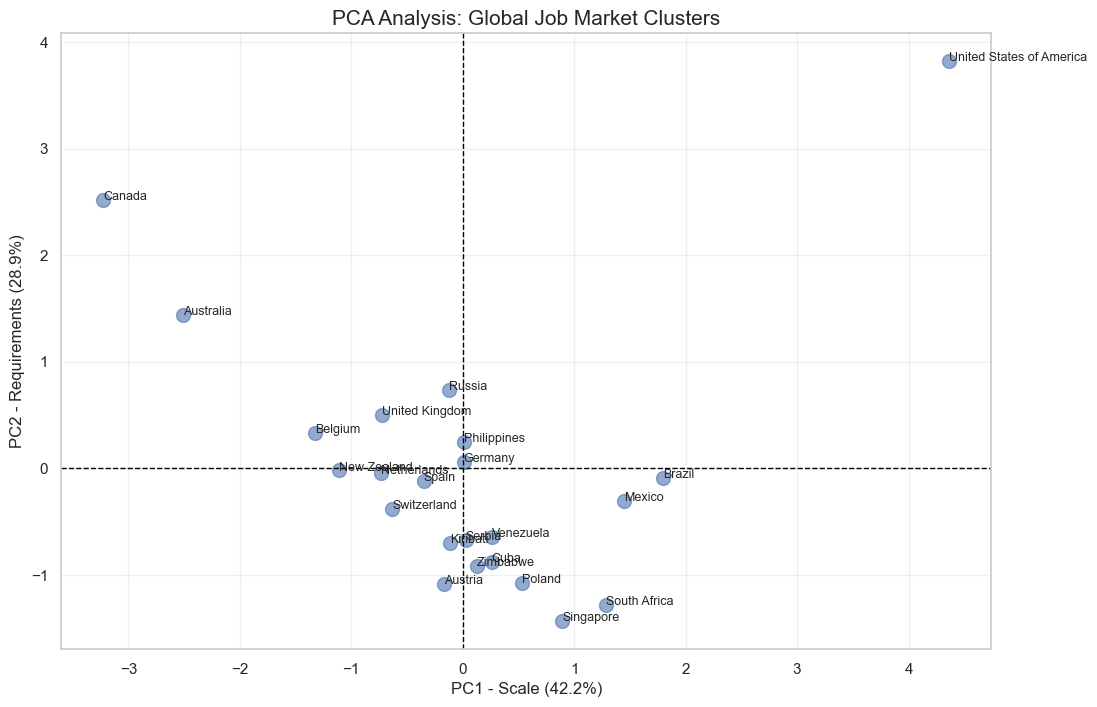

=== VARIABLE LOADINGS ===
                     PC1       PC2
total_jobs      0.474448  0.524432
role_count      0.423182 -0.464751
skill_count     0.538353 -0.375461
min_salary      0.278494 -0.332363
population_num  0.477946  0.507485


In [ ]:
# STEP 4.1: UNSUPERVISED MODELING – PCA

# Step 4.1.1: FEATURE ENGINEERING & CLEANING
def count_items(text):
    if pd.isna(text) or str(text).strip() == "" or str(text).lower() == 'nan':
        return 0
    return len([i.strip() for i in str(text).split(',') if i.strip() != ""])

# Create proxy for roles from industry and skills from job_description
df['role_count'] = df['roles'].astype(str).apply(count_items)
df['skill_count'] = df['skills'].astype(str).apply(count_items)

# Convert salary and population to numeric, handling missing values with the median
df['min_salary_usd'] = pd.to_numeric(df['min_salary'], errors='coerce')
df['population_num'] = pd.to_numeric(df['population'], errors='coerce')

# STEP 4.1.2: AGGREGATION BY COUNTRY
# We aggregate to find the "average" market profile for each country
df_country_stats = df.groupby('country').agg({
    'job_id': 'count',
    'role_count': 'mean',
    'skill_count': 'mean',
    'min_salary': 'median', # Using median due to high sparsity in salary data
    'population_num': 'first'
}).rename(columns={'job_id': 'total_jobs'}).dropna()

# STEP 4.1.3: PCA EXECUTION
features = ['total_jobs', 'role_count', 'skill_count', 'min_salary', 'population_num']
x = df_country_stats[features]

# Standardize the data (Mean=0, Variance=1)
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(x_std)

# Create a DataFrame for the results
pca_df = pd.DataFrame(data=pc_scores,
                      columns=['PC1 (Market Scale)', 'PC2 (Job Requirements)'],
                      index=x.index)

# STEP 4.1.4: VISUALIZATION
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1 (Market Scale)'], pca_df['PC2 (Job Requirements)'], alpha=0.6, s=100)

for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]), fontsize=9)

plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.title('PCA Analysis: Global Job Market Clusters', fontsize=15)
plt.xlabel(f'PC1 - Scale ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 - Requirements ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True, alpha=0.3)
plt.show()

# Show variable influence
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("=== VARIABLE LOADINGS ===")
print(loadings)

Clustering based on: ['PC1 (Market Scale)', 'PC2 (Job Requirements)']


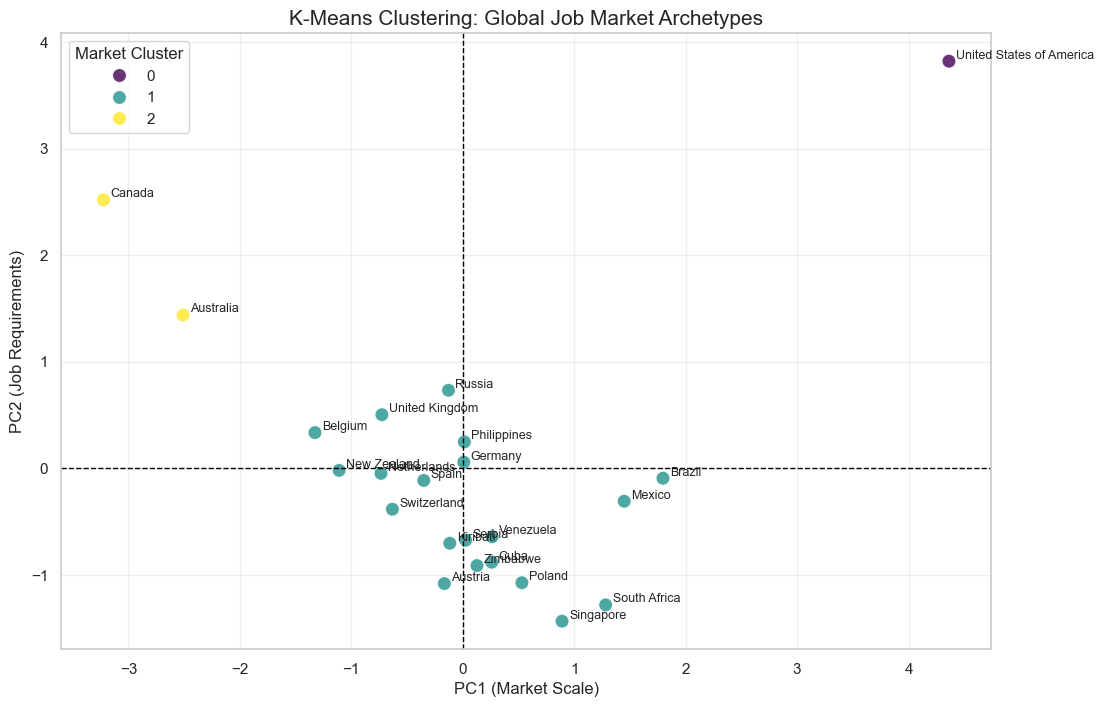

Cluster 0: United States of America
Cluster 1: Austria, Belgium, Brazil, Cuba, Germany, Kiribati, Mexico, Netherlands, New Zealand, Philippines, Poland, Russia, Serbia, Singapore, South Africa, Spain, Switzerland, United Kingdom, Venezuela, Zimbabwe
Cluster 2: Australia, Canada


In [ ]:
# STEP 4.2: K-MEANS CLUSTERING ON PCA SPACE
# Prepare PCA DataFrame for Clustering (chuẩn bị chạy KMeans trên không gian PCA)

# STEP 4.2.1: Automatically detect the PCA column names to avoid KeyErrors
pca_cols = pca_df.columns[:2].tolist()
print(f"Clustering based on: {pca_cols}")

# STEP 4.2.2: Run K-Means
# We use .fit_predict() which is cleaner for assigning cluster labels
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[pca_cols])

# STEP 4.2.3: Visualize the Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x=pca_cols[0], y=pca_cols[1],
                hue='Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='w')

# Annotate country names for clarity
for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df.iloc[i, 0], pca_df.iloc[i, 1]),
                 fontsize=9, xytext=(5,2), textcoords='offset points')

plt.title('K-Means Clustering: Global Job Market Archetypes', fontsize=15)
plt.axhline(0, color='black', lw=1, ls='--')
plt.axvline(0, color='black', lw=1, ls='--')
plt.grid(True, alpha=0.3)
plt.legend(title='Market Cluster')
plt.show()

# STEP 4.2.4: View which countries fell into which cluster
for cluster_id in range(3):
    countries = pca_df[pca_df['Cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id}: {', '.join(countries)}")

In [ ]:
# STEP 4.2: K-MEANS CLUSTERING ON PCA SPACE

# STEP 4.2.5: Check df
df.head()

,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd,skills,role_count,skill_count,population_num
0,119761,17828,4493,2025-05-31,120000.0,140000.0,USD,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.662579,172.701926,4917000.0,,Lead,nan,nan,nan,1.0,120000.0,140000.0,130000.0,,0,0,4917000.0
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.705628,-112.599436,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev...",1.0,NaN,NaN,NaN,"Azure, AWS, Kafka, Terrafo...",1,9,328239523.0
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.873200,-157.429600,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V...",1.0,NaN,NaN,NaN,"Azure, Python, AWS, GCP, G...",1,8,312000.0
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.148260,19.311014,37970874.0,Data Analyst,NaN,nan,nan,nan,1.0,NaN,NaN,NaN,,1,0,37970874.0
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.705628,-112.599436,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ...",1.0,NaN,NaN,NaN,"SQL, Python, Spark, PowerP...",1,4,328239523.0


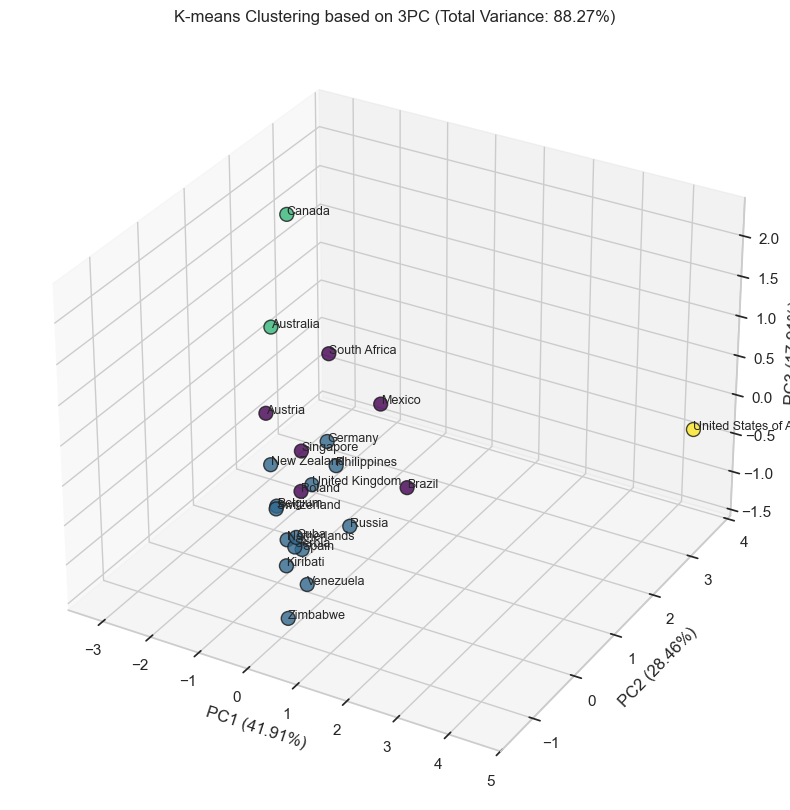

PCA 3D Loadings:
                     PC1       PC2       PC3
total_jobs      0.486265  0.516004 -0.014903
role_count      0.418170 -0.498914 -0.406074
skill_count     0.529094 -0.395052 -0.136208
avg_salary_usd  0.254798 -0.296580  0.902679
population      0.493780  0.490712  0.038723


In [ ]:
# STEP 4.3: PCA-BASED 3D K-MEANS CLUSTERING
# Dùng để vẽ đồ thị 3D

# STEP 4.3.1: PCA VỚI 3 THÀNH PHẦN CHÍNH ---
# Sử dụng df_zscore từ bước trước của bạn
data_pca_3d = df_zscore.dropna()
pca_3 = PCA(n_components=3)
pca_results_3d = pca_3.fit_transform(data_pca_3d)

# Tạo DataFrame chứa kết quả 3PC
df_3pc = pd.DataFrame(
    data = pca_results_3d,
    columns = ['PC1', 'PC2', 'PC3'],
    index = data_pca_3d.index
).reset_index()

# STEP 4.3.2: K-MEANS CLUSTERING DỰA TRÊN 3PC
# Giả sử chúng ta chọn K=4 cụm để phân hóa rõ hơn các nhóm nước
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_3pc['cluster'] = kmeans.fit_predict(pca_results_3d) # Chạy trên cả 3 cột PC

# STEP 4.3.3: TRỰC QUAN HÓA 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Vẽ các điểm dữ liệu theo 3 trục PC, màu sắc theo Cluster
scatter = ax.scatter(df_3pc['PC1'], df_3pc['PC2'], df_3pc['PC3'],
                     c=df_3pc['cluster'], cmap='viridis', s=100, edgecolors='k', alpha=0.8)

# Thêm nhãn tên quốc gia (để tránh rối, chỉ hiện nhãn cho một số nước tiêu biểu)
for i in range(df_3pc.shape[0]):
    ax.text(df_3pc.PC1[i], df_3pc.PC2[i], df_3pc.PC3[i], df_3pc['country'][i], size=9)

# Giải thích các trục
pc_vars = pca_3.explained_variance_ratio_ * 100
ax.set_xlabel(f'PC1 ({pc_vars[0]:.2f}%)')
ax.set_ylabel(f'PC2 ({pc_vars[1]:.2f}%)')
ax.set_zlabel(f'PC3 ({pc_vars[2]:.2f}%)')

plt.title(f'K-means Clustering based on 3PC (Total Variance: {pc_vars.sum():.2f}%)')
plt.show()

# In Loadings để giải thích PC3 là gì
loadings_3d = pd.DataFrame(pca_3.components_.T, columns=['PC1', 'PC2', 'PC3'], index=cols_to_zscore)
print("PCA 3D Loadings:")
print(loadings_3d)

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\3127844482.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_data = df.groupby('country').agg({


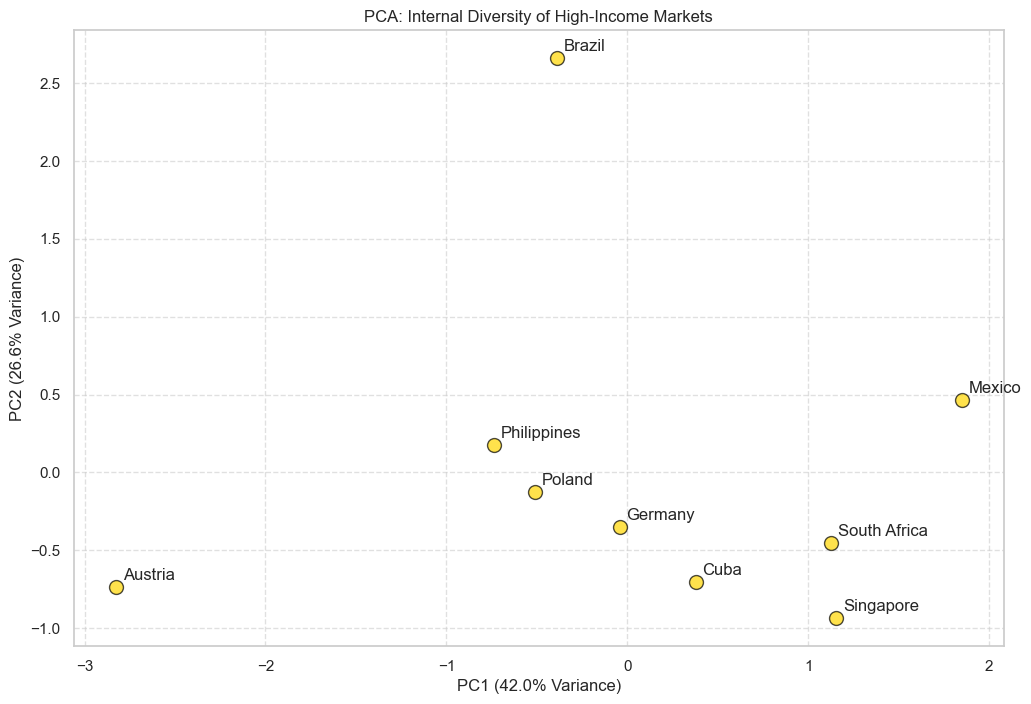

Loadings Analysis:
                  PC1       PC2
total_jobs   0.664399 -0.240478
role_count  -0.427341  0.219730
skill_count  0.603928  0.260601
population   0.105947  0.908832


In [ ]:
# STEP 4.4: FOCUSED PCA ANALYSIS OF HIGH-INCOME MARKETS

# STEP 4.4.1: Tổng hợp dữ liệu theo quốc gia (vì PCA cần so sánh giữa các quốc gia)
country_data = df.groupby('country').agg({
    'avg_salary_usd': 'mean',
    'job_id': 'count',          # Đây chính là total_jobs
    'role_count': 'mean',
    'skill_count': 'mean',
    'population': 'first'       # Lấy giá trị dân số đầu tiên của quốc gia đó
}).rename(columns={'job_id': 'total_jobs'}).dropna()

# STEP 4.4.2: Bây giờ mới lọc nhóm "thu nhập cao" từ bảng đã tổng hợp
high_income_countries = country_data[country_data['avg_salary_usd'] > 140000].copy()

# STEP 4.4.3: Chọn các biến làm PCA
features = ['total_jobs', 'role_count', 'skill_count', 'population']
x = high_income_countries[features]

# STEP 4.4.4: Chuẩn hóa và chạy PCA
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca_high = PCA(n_components=2)
pc_results = pca_high.fit_transform(x_scaled)

# STEP 4.4.5: Tạo DataFrame kết quả để vẽ biểu đồ có tên quốc gia
pca_df = pd.DataFrame(data=pc_results, columns=['PC1', 'PC2'], index=high_income_countries.index)

# STEP 4.4.6: Vẽ biểu đồ PCA có tên quốc gia (Annotate)
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], s=100, alpha=0.7, c='gold', edgecolors='black')

for i, txt in enumerate(pca_df.index):
    plt.annotate(txt, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), xytext=(5,5), textcoords='offset points')

plt.title('PCA: Internal Diversity of High-Income Markets')
plt.xlabel(f'PC1 ({pca_high.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'PC2 ({pca_high.explained_variance_ratio_[1]:.1%} Variance)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Xuất Loadings để phân tích
loadings = pd.DataFrame(pca_high.components_.T, columns=['PC1', 'PC2'], index=features)
print("Loadings Analysis:")
print(loadings)

C:\Users\Zyro\AppData\Local\Temp\ipykernel_17080\1100978959.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skills_df, x='Count', y='Skill', palette='magma')


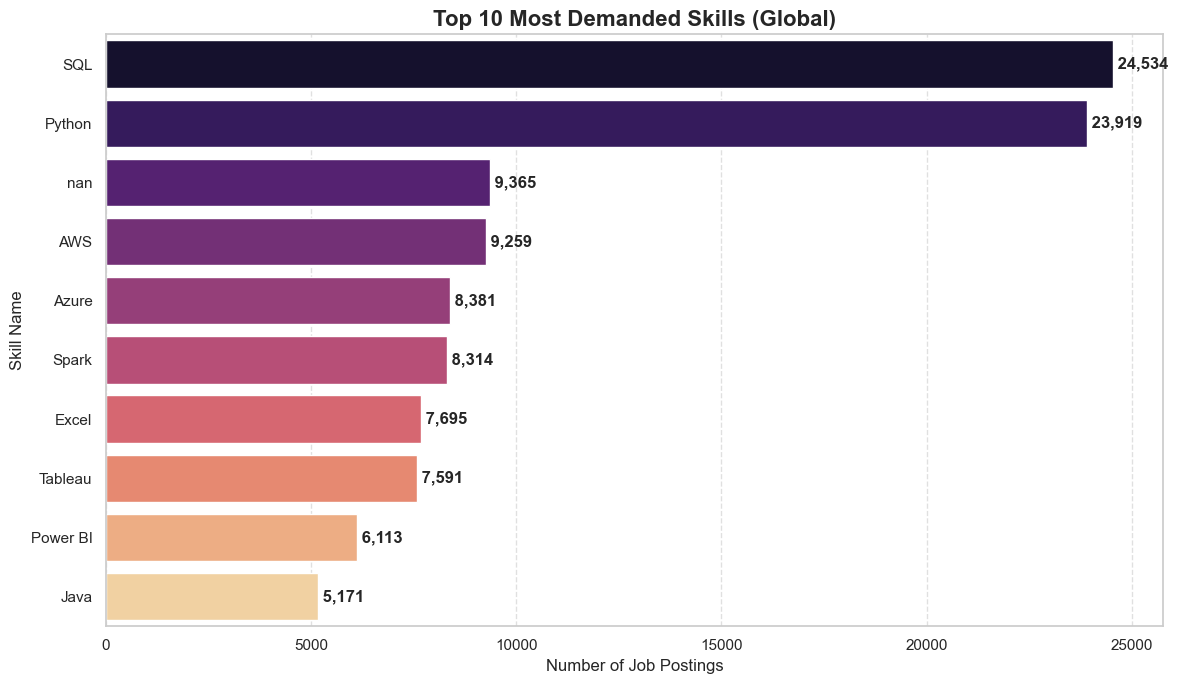

In [ ]:
# STEP 4.5 GLOBAL SKILL DEMAND ANALYSIS

# STEP 4.5.1: Identify the correct column (using 'skill_names' from your dataset)
source_col = 'skill_names'

# STEP 4.5.2: Extract and flatten the skills list
# We split by comma, drop nulls, and flatten the list of lists into one long list
all_skills_list = []
df[source_col].dropna().apply(lambda x: all_skills_list.extend([s.strip() for s in str(x).split(',') if s.strip()]))

# STEP 4.5.3. Count frequencies and create a DataFrame
skill_counts = Counter(all_skills_list).most_common(10)
skills_df = pd.DataFrame(skill_counts, columns=['Skill', 'Count'])

# STEP 4.5.4. Plotting
plt.figure(figsize=(12, 7))
sns.barplot(data=skills_df, x='Count', y='Skill', palette='magma')

# Add data labels for clarity
for index, value in enumerate(skills_df['Count']):
    plt.text(value, index, f' {value:,.0f}', va='center', fontweight='bold')

plt.title('Top 10 Most Demanded Skills (Global)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Job Postings')
plt.ylabel('Skill Name')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# STEP 4.5 GLOBAL SKILL DEMAND ANALYSIS

# Step 4.5.5: Check df
df.head()

,job_id,company_id,location_id,posted_date,min_salary,max_salary,currency,required_exp_years,education_level,employment_type,job_description,remote_option,company_name,size,industry,city,country,country_iso,latitude,longitude,population,roles,job_level,skill_names,skill_ids,skill_categories,ex_rate,min_salary_usd,max_salary_usd,avg_salary_usd,skills,role_count,skill_count,population_num
0,119761,17828,4493,2025-05-31,120000.0,140000.0,USD,NaN,Master,Full-time,Enterprise Account Executi...,Remote,Maslow,Enterprise,Technology,Auckland,New Zealand,NZ,-41.662579,172.701926,4917000.0,,Lead,nan,nan,nan,1.0,120000.0,140000.0,130000.0,,0,0,4917000.0
1,1088383,153166,4700,2025-01-11,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,MASTER PLUS HUMAN RESOURCE...,NaN,NaN,Oshkosh,United States of America,US,45.705628,-112.599436,328239523.0,Data Engineer,NaN,"Azure, AWS, Kafka, Terrafo...","1, 10, 11, 17, 18, 20, 23,...","Cloud,Data Engineering,Dev...",1.0,NaN,NaN,NaN,"Azure, AWS, Kafka, Terrafo...",1,9,328239523.0
2,853689,32657,1406,2024-06-08,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,RemoteWorker UK,NaN,NaN,London Village,Kiribati,KI,1.873200,-157.429600,312000.0,Data Scientist,NaN,"Azure, Python, AWS, GCP, G...","1, 9, 10, 15, 37, 57, 134,...","Cloud,Programming,DevOps,V...",1.0,NaN,NaN,NaN,"Azure, Python, AWS, GCP, G...",1,8,312000.0
3,850850,95060,5439,2024-06-03,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,25-я городская детская пол...,NaN,NaN,Minsk Mazowiecki,Poland,PL,52.148260,19.311014,37970874.0,Data Analyst,NaN,nan,nan,nan,1.0,NaN,NaN,NaN,,1,0,37970874.0
4,920654,66126,5394,2024-09-12,NaN,NaN,NaN,NaN,NaN,Full-time,__NA__,Onsite,Bbva Renting,NaN,NaN,Bogota,United States of America,US,45.705628,-112.599436,328239523.0,Data Analyst,NaN,"SQL, Python, Spark, PowerP...","8, 9, 18, 41","Database,Programming,Data ...",1.0,NaN,NaN,NaN,"SQL, Python, Spark, PowerP...",1,4,328239523.0


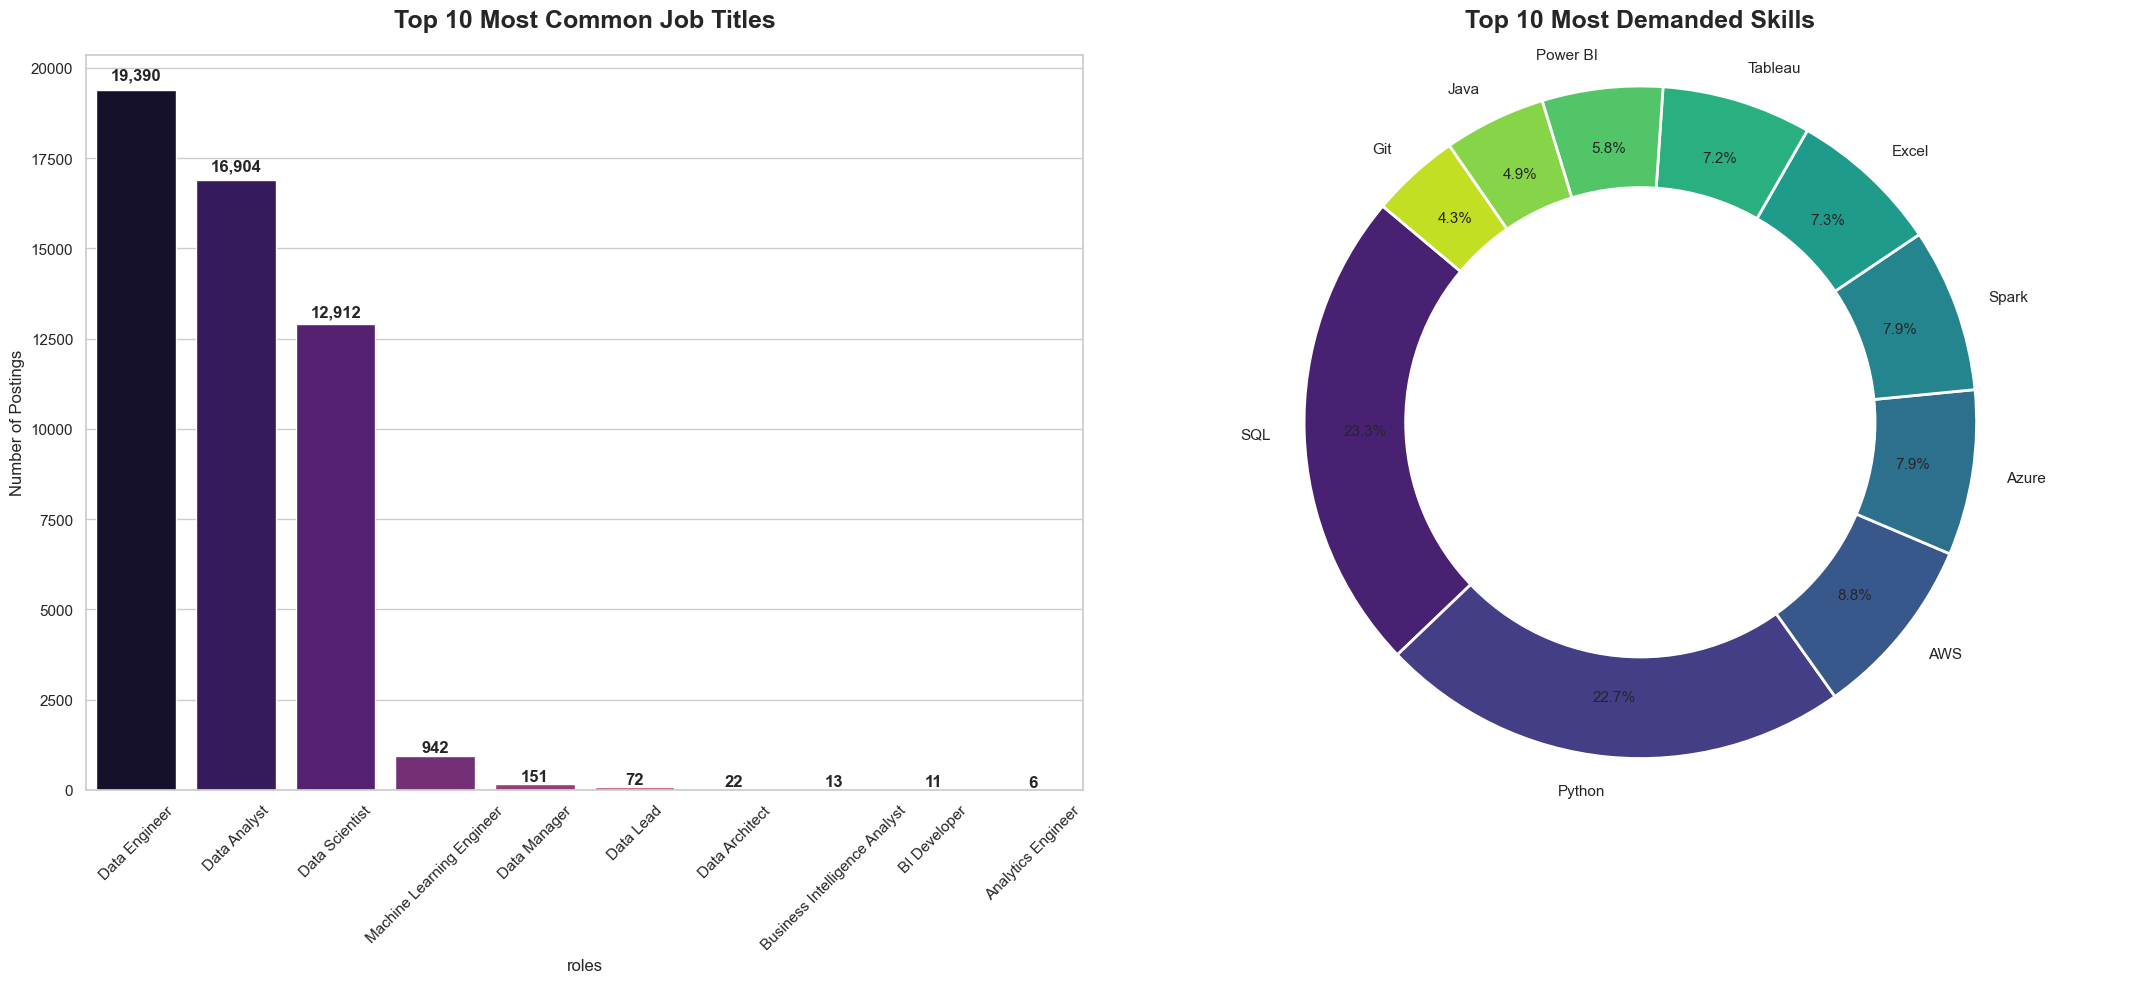

In [ ]:
# STEP 4.6: GLOBAL JOB TITLE AND SKILL DEMAND ANALYSIS

# STEP 4.6.1: Data Processing

# Process Skills
all_skills_list = []
df['skill_names'].dropna().apply(
    lambda x: all_skills_list.extend(
        [s.strip() for s in str(x).split(',') if s.strip().lower() != 'nan']
    )
)
skills_df = pd.DataFrame(
    Counter(all_skills_list).most_common(10),
    columns=['Skill', 'Count']
)

# Process Job Titles
all_titles_list = []
df['roles'].dropna().apply(
    lambda x: all_titles_list.extend(
        [t.strip() for t in str(x).split(',') if t.strip()]
    )
)
jobs_df = pd.DataFrame(
    Counter(all_titles_list).most_common(10),
    columns=['roles', 'Count']
)

# STEP 4.6.2: Plotting

fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# ===== LEFT: Job Titles (Bar Chart) =====
sns.barplot(
    data=jobs_df,
    x='roles',
    y='Count',
    ax=axes[0],
    palette='magma',
    hue='roles'
)
if axes[0].get_legend():
    axes[0].get_legend().remove()

axes[0].set_title(
    'Top 10 Most Common Job Titles',
    fontsize=18,
    fontweight='bold',
    pad=20
)
axes[0].tick_params(axis='x', rotation=45, labelsize=11)
axes[0].set_ylabel('Number of Postings', fontsize=12)

# Add data labels
for index, value in enumerate(jobs_df['Count']):
    axes[0].text(
        index,
        value + value * 0.01,
        f'{value:,.0f}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# ===== RIGHT: Skills (Donut Chart) =====
colors = sns.color_palette('viridis', n_colors=len(skills_df))
wedges, texts, autotexts = axes[1].pie(
    skills_df['Count'],
    labels=skills_df['Skill'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.82,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 11}
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axes[1].add_artist(centre_circle)

axes[1].set_title(
    'Top 10 Most Demanded Skills',
    fontsize=18,
    fontweight='bold',
    pad=20
)
axes[1].axis('equal')

plt.tight_layout()
plt.show()
